# Complex body TFA Inversion

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA) data on a regular grid of a model with a complex geometry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.vis import mpl

/home/leo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
from datetime import datetime
today = datetime.today()
# dd/mm/YY/Hh/Mm
d4 = today.strftime("%d-%b-%Y-%Hh:%Mm")

### Auxiliary functions

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [4]:
with open('model.pickle') as w:
        model = pickle.load(w)

### Observation points and observed data

In [5]:
with open('data.pickle') as w:
        data = pickle.load(w)

In [6]:
# observed data and observation points
dobs = data['tfa_obs']
xp = data['x']
yp = data['y']
zp = data['z']
N = data['N']

### Parameters of the initial model

In [7]:
M = 20 # number of vertices per prism
L = 10 # number of prisms
P = L*(M+2) + 1 # number of parameters

# depth to the top, thickness, origin, magnetization and radius
incs = model['inc']
decs = model['dec']
intensity = 12.6 #model['intensity']
z0 = 150. #model['z0']
dz = 650.
r = 800.
x0 = -300.
y0 = 300.

# main field
inc, dec = data['main_field']

model0, m0 = mfun.initial_cylinder(M, L, x0,
        y0, z0, dz, r, inc, dec, incs, decs, intensity)

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

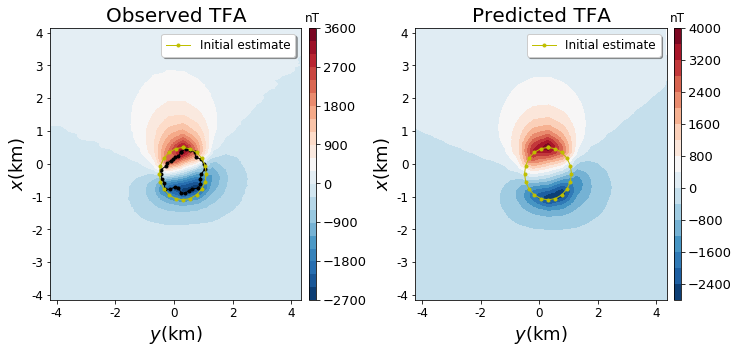

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-y', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.subplot(122)
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-y', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.show()

### Outcropping parameters

In [9]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Limits

In [10]:
# limits for parameters in meters
rmin = 10.
rmax = 3000.
x0min = -4000.
x0max = 4000.
y0min = -4000.
y0max = 4000.
dzmin = 200.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Derivatives

In [11]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

delta = np.array([deltax, deltay, deltar, deltaz])

### Regularization parameters

In [12]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-5  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4   # vertically adjacent origins
a6 = 1.0e-7   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-6     # zero order Tikhonov on thickness of each prism

alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

### Folder to save the results

In [13]:
foldername = 'test'

### Iterations and stop criterion

In [14]:
itmax = 30       # maximum iteration
itmax_marq = 10  # maximum iteration of Marquardt's loop
tol = 1.0e-3     # stop criterion

### Inversion

In [15]:
d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_tf(
    xp, yp, zp, m0, M, L, delta,
    itmax, itmax_marq, lamb,
    dlamb, tol, mmin, mmax,
    m_out, dobs, inc, dec,
    model0[0].props, alpha, z0, dz
)

it:  0   it_marq:  0   lambda: 1e+01   init obj.: 2.81123e+04  fin obj.: 1.08885e+04
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 1.08885e+04  fin obj.: 1.95609e+03
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 1.95609e+03  fin obj.: 3.13352e+02
it:  3   it_marq:  0   lambda: 1e-02   init obj.: 3.13352e+02  fin obj.: 8.83239e+01
it:  4   it_marq:  0   lambda: 1e-03   init obj.: 8.83239e+01  fin obj.: 3.16135e+02
it:  4   it_marq:  1   lambda: 1e-02   init obj.: 8.83239e+01  fin obj.: 1.68305e+02
it:  4   it_marq:  2   lambda: 1e-01   init obj.: 8.83239e+01  fin obj.: 6.38297e+01
it:  5   it_marq:  0   lambda: 1e-02   init obj.: 6.38297e+01  fin obj.: 1.52830e+02
it:  5   it_marq:  1   lambda: 1e-01   init obj.: 6.38297e+01  fin obj.: 6.36133e+01
it:  6   it_marq:  0   lambda: 1e-02   init obj.: 6.36133e+01  fin obj.: 1.50090e+02
it:  6   it_marq:  1   lambda: 1e-01   init obj.: 6.36133e+01  fin obj.: 6.30985e+01
it:  7   it_marq:  0   lambda: 1e-02   init obj.: 6.30985e+01  fi

# Results

In [16]:
# output of inversion
inversion = dict()

inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['initial_estimate'] = model0
inversion['initial_data'] = d0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [-21.5, -18.7]
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['estimated_models'] = model_list
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit
inversion['residual_list'] = res_list

### Saving results

In [17]:
if foldername == '':
    mypath = 'results/single-'+d4 #default folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)
else:
    mypath = 'results/single-'+foldername #defined folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)

In [18]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)